In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, scale
from os import listdir
import keras
#import squarify
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 1000) 

In [112]:
pd.options.display.max_columns = None
frames = []
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]
def find_soccer_files(dirname):
    filenames = find_csv_filenames(dirname)
    for name in filenames:
        try:
            name = dirname + name
            df = pd.read_csv(name, engine='python')
            #print('The shape is' + str(df.shape) + 'in the file' + name)
            df = (df[['Div', 'HomeTeam', 'AwayTeam',
                    'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
                    'HTR', 'HS', 'AS', 'HST', 'AST',
                    'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']])
            #print('The new shape is' + str(df.shape) + 'in the file' + name)
            frames.append(df)
        except Exception as error:
            print(error)
            
find_soccer_files('eng_premier_league/')
find_soccer_files('eng_championship/')
find_soccer_files('eng_league_1/')
find_soccer_files('eng_league_2/') 
find_soccer_files('eng_conference/')

df1 = pd.concat(frames)
#print(df1.shape)
df1.head()
df1 = df1.dropna(axis=0)
print(df1['Div'].unique())
df1.head()

"['HS' 'AS' 'HST' 'AST' 'HF' 'AF' 'HC' 'AC'] not in index"
"['HS' 'AS' 'HST' 'AST' 'HF' 'AF' 'HC' 'AC'] not in index"
['E0' 'E1' 'E2' 'E3' 'EC']


,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0
1,E0,Everton,Man United,0.0,2.0,A,0.0,1.0,A,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0
2,E0,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0
3,E0,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0
4,E0,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0


In [113]:
df1['home_team_chance_to_draw_home_total'] = 0.0
df1['home_team_chance_to_win_home_total'] = 0.0
df1['home_team_chance_to_lose_home_total'] = 0.0
df1['home_team_chance_to_win_agaisnt_away'] = 0.0
df1['home_team_chance_to_draw_agaisnt_away'] = 0.0
df1['home_team_chance_to_lose_agaisnt_away'] = 0.0

for home_team in df1['HomeTeam'].unique():
    home_team_total_ammount_games = df1.loc[df1['HomeTeam'] == home_team]
    if len(home_team_total_ammount_games) == 0:
        continue
    # Chance of Home Team Winning in All Games
    home_team_chance_to_win_total = df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'H')]
    # Percentage of winning chance at home
    home_team_change_to_win_total_percentage = len(home_team_chance_to_win_total) / len(home_team_total_ammount_games)
    # Chance of Home Team Drawing in All Games
    home_team_chance_to_draw_total = df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'D')]
    # Percentage of drawing chance at home
    home_team_change_to_draw_total_percentage = len(home_team_chance_to_draw_total) / len(home_team_total_ammount_games)
    # Chance of Home Team Losing in All Games
    home_team_chance_to_lose_total = df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'A')]
    # Percentage of losing chance at home
    home_team_change_to_lose_total_percentage = len(home_team_chance_to_lose_total) / len(home_team_total_ammount_games)
    df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_win_home_total']] = home_team_change_to_win_total_percentage
    df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_lose_home_total']] = home_team_change_to_lose_total_percentage
    df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_draw_home_total']] = home_team_change_to_draw_total_percentage
    for away_team in df1['AwayTeam'].unique():
        
        # Chance of Home Team Play agaisn't away
        home_team_chance_to_play_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team)]
        if len(home_team_chance_to_play_away) == 0:
            continue
        # Chance of Home Team win agaisn't away
        home_team_chance_to_win_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'H')]
        
        # Chance of Home Team draw agaisn't away
        home_team_chance_to_draw_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'D')]
        
        # Chance of Home Team lose agaisn't away
        home_team_chance_to_lose_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'A')]
        
        # Percentage of Home Team change to win agaisn't away
        home_team_chance_to_win_away_percentage = len(home_team_chance_to_win_away)/len(home_team_chance_to_play_away)
        #print('Chance of home team: ', home_team, " winning agaisn't away: ", away_team, ' are: ', str(home_team_chance_to_win_away_percentage))
        
        # Percentage of Home Team change to win agaisn't away
        home_team_chance_to_lose_away_percentage = len(home_team_chance_to_lose_away)/len(home_team_chance_to_play_away)
        #print('Chance of home team: ', home_team, " losing agaisn't away: ", away_team, ' are: ', str(home_team_chance_to_lose_away_percentage))
        
        # Percentage of Home Team change to win agaisn't away
        home_team_chance_to_draw_away_percentage = len(home_team_chance_to_draw_away)/len(home_team_chance_to_play_away)
        #print('Chance of home team: ', home_team, " drawing agaisn't away: ", away_team, ' are: ', str(home_team_chance_to_draw_away_percentage))
        df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team), ['home_team_chance_to_win_agaisnt_away']] = home_team_chance_to_win_away_percentage
        df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team), ['home_team_chance_to_lose_agaisnt_away']] = home_team_chance_to_lose_away_percentage
        df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team), ['home_team_chance_to_draw_agaisnt_away']] = home_team_chance_to_draw_away_percentage
df1.to_csv('optimized_data.csv', sep=',')
    


,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,home_team_chance_to_draw_home_total,home_team_chance_to_win_home_total,home_team_chance_to_lose_home_total,home_team_chance_to_win_agaisnt_away,home_team_chance_to_draw_agaisnt_away,home_team_chance_to_lose_agaisnt_away
0,E0,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0.321569,0.368627,0.309804,0.500000,0.250000,0.250000
1,E0,Everton,Man United,0.0,2.0,A,0.0,1.0,A,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0.255061,0.522267,0.222672,0.307692,0.230769,0.461538
2,E0,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0.243346,0.444867,0.311787,0.375000,0.375000,0.250000
3,E0,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0.157895,0.668016,0.174089,0.900000,0.100000,0.000000
4,E0,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0.279570,0.458781,0.261649,0.200000,0.600000,0.200000


In [136]:
games = df1

games['HTR'] = games['HTR'].replace('H', 2).replace('D', 1).replace('A', 0)
games['FTR'] = games['FTR'].replace('H', 2).replace('D', 1).replace('A', 0)
i = 1
for home_team in games['HomeTeam'].unique():
    
    games.loc[(games['AwayTeam'] == home_team), ['AwayTeam']] = i
    games.loc[(games['HomeTeam'] == home_team), ['HomeTeam']] = i

    #print('Team ' + str(home_team) + ' is equivalent to ' + str(i))
    i += 1


results = games['HTR']

#games = games.drop(['HTR'], axis=1)





In [137]:
i = 1

for division in games['Div'].unique():
    
    games.loc[(games['Div'] == division), ['Div']] = i
    i = i + 1


In [138]:
games.head(15)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,home_team_chance_to_draw_home_total,home_team_chance_to_win_home_total,home_team_chance_to_lose_home_total,home_team_chance_to_win_agaisnt_away,home_team_chance_to_draw_agaisnt_away,home_team_chance_to_lose_agaisnt_away
0,1,1,19,2.0,2.0,1,2.0,2.0,1,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0.321569,0.368627,0.309804,0.500000,0.250000,0.250000
1,1,2,15,0.0,2.0,0,0.0,1.0,0,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0.255061,0.522267,0.222672,0.307692,0.230769,0.461538
2,1,3,11,0.0,0.0,1,0.0,0.0,1,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0.243346,0.444867,0.311787,0.375000,0.375000,0.250000
3,1,4,18,0.0,0.0,1,0.0,0.0,1,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0.157895,0.668016,0.174089,0.900000,0.100000,0.000000
4,1,5,14,0.0,0.0,1,0.0,0.0,1,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0.279570,0.458781,0.261649,0.200000,0.600000,0.200000
5,1,6,17,0.0,2.0,0,0.0,1.0,0,11.0,11.0,7.0,6.0,13.0,23.0,7.0,2.0,0.0,2.0,0.0,0.0,0.254480,0.419355,0.326165,0.200000,0.200000,0.600000
6,1,7,13,1.0,3.0,0,1.0,1.0,1,12.0,14.0,8.0,4.0,15.0,17.0,5.0,5.0,2.0,0.0,0.0,1.0,0.274510,0.313725,0.411765,0.000000,0.000000,1.000000
7,1,8,12,3.0,1.0,2,0.0,1.0,0,13.0,11.0,5.0,5.0,11.0,14.0,2.0,6.0,0.0,1.0,0.0,1.0,0.247012,0.414343,0.338645,0.666667,0.333333,0.000000
8,1,9,16,2.0,0.0,2,0.0,0.0,1,15.0,2.0,12.0,1.0,15.0,17.0,8.0,3.0,0.0,1.0,0.0,1.0,0.214575,0.672065,0.113360,0.818182,0.090909,0.090909
9,1,10,20,0.0,1.0,0,0.0,0.0,1,12.0,20.0,5.0,9.0,14.0,7.0,2.0,6.0,1.0,0.0,0.0,0.0,0.307116,0.355805,0.337079,0.125000,0.125000,0.750000


In [139]:
print('Correlation between Half Time Result and Away Red Cards')
print(np.corrcoef(games['HTR'], games['AR']))
print('Correlation between Full Time Result and Away Red Cards')
print(np.corrcoef(games['FTHG'], games['HR']))
print(np.corrcoef(games['HTR'], games['FTR']))
chance_win = ([games['FTR'] == games['HTR']])
a = np.array(chance_win, dtype=np.int)
chance_win = np.sum(a)
print(chance_win / 6687)

Correlation between Half Time Result and Away Red Cards
[[ 1.          0.04728487]
 [ 0.04728487  1.        ]]
Correlation between Full Time Result and Away Red Cards
[[ 1.         -0.06492051]
 [-0.06492051  1.        ]]
[[ 1.          0.57792276]
 [ 0.57792276  1.        ]]
2.8498579333


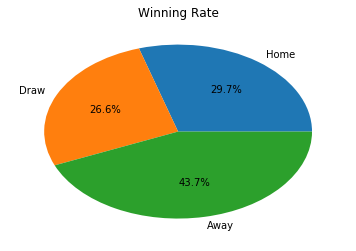

In [140]:
win_home = np.sum(games['FTR'] == 0)
draw = np.sum(games['FTR'] == 1)
win_away = np.sum(games['FTR'] == 2)
results_pie = [win_home, draw, win_away]
labels = ['Home', 'Draw', 'Away']
plt.title('Winning Rate')
plt.pie(results_pie, labels=labels, autopct='%1.1f%%')
plt.show()

In [141]:
X = games.drop(['FTHG', 'FTAG'], axis=1)

Y = games[['FTHG', 'FTAG']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = scale(X_train)
y_train = scale(y_train)
X_test = scale(X_test)
y_test = scale(y_test)
print(X_train.shape)
print(y_train.shape)

(22680, 25)
(22680, 2)


In [142]:
model = Sequential()

In [143]:
model.add(Dense(800, activation='relu', input_shape=(25,)))
model.add(Dropout(0.5))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [144]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 800)               20800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 120)               96120     
_________________________________________________________________
dropout_18 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 242       
Total params: 117,162
Trainable params: 117,162
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [146]:
history = model.fit(X_train, y_train,batch_size=4000, epochs=500,verbose=2, validation_data=(X_test, y_test))

Train on 22680 samples, validate on 9721 samples
Epoch 1/500
 - 1s - loss: 1.2722 - acc: 0.5203 - val_loss: 1.2448 - val_acc: 0.5778
Epoch 2/500
 - 0s - loss: 1.2554 - acc: 0.5463 - val_loss: 1.2255 - val_acc: 0.6594
Epoch 3/500
 - 0s - loss: 1.2372 - acc: 0.5795 - val_loss: 1.2072 - val_acc: 0.7250
Epoch 4/500
 - 0s - loss: 1.2207 - acc: 0.6069 - val_loss: 1.1902 - val_acc: 0.7680
Epoch 5/500
 - 0s - loss: 1.2062 - acc: 0.6325 - val_loss: 1.1743 - val_acc: 0.7997
Epoch 6/500
 - 0s - loss: 1.1929 - acc: 0.6616 - val_loss: 1.1595 - val_acc: 0.8178
Epoch 7/500
 - 0s - loss: 1.1776 - acc: 0.6841 - val_loss: 1.1456 - val_acc: 0.8337
Epoch 8/500
 - 0s - loss: 1.1656 - acc: 0.7011 - val_loss: 1.1326 - val_acc: 0.8432
Epoch 9/500
 - 0s - loss: 1.1524 - acc: 0.7180 - val_loss: 1.1206 - val_acc: 0.8484
Epoch 10/500
 - 0s - loss: 1.1446 - acc: 0.7320 - val_loss: 1.1093 - val_acc: 0.8541
Epoch 11/500
 - 0s - loss: 1.1352 - acc: 0.7424 - val_loss: 1.0988 - val_acc: 0.8569
Epoch 12/500
 - 0s - loss

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=2)

In [ ]:
print('Test Loss:', scores[0])
print('Test Accuracy', scores[1])

Test Loss: 0.914881914449
Test Accuracy 0.990355107409


In [ ]:
#prediction = model.predict()
#print(prediction)